<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

## **Packages, Constants & Functions**

In [51]:
# Preprocessing
CROP_SIZE_ = 28
MEAN_ = 0.1307
STD_ = 0.3081
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 50
BATCH_SIZE_ = 100
TRAIN_SIZE_ = 50000
TEST_SIZE_ = 10000

# Receprive fields visualization
VISUALIZATION_THRESH_ = 0.1

# Alphabets
# key - alphabet, value - start and finish labels
ALPHABETS_DICT_ = {
    'First': [0, 25]  # Label limits
}

# Model
VISIBLE_UNITS_ = IMG_SIZE_ * IMG_SIZE_
HIDDEN_UNITS_ = [500, 500]
N_HIDDEN_LAYERS_ = len(HIDDEN_UNITS_)
K_ = 1
LEARNING_RATE_ = 0.1
LR_DECAY_ = False
INIT_MOMENTUM_ = 0.5
FIN_MOMENTUM_ = 0.9
W_DECAY_ = 0.00002
XAVIER_INIT_ = False
INCREASE_TO_CD_K_ = False
USE_GPU_ = True

In [1]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [3]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from google.colab import drive
from os import path
import pickle

# Utils
from scipy import cluster
import numpy as np
import random
import math

# Plotting
import seaborn as sns

In [4]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [18]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [47]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_labels(labels, data, targets):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        label = labels[i]
        
        img_index = np.where(targets == label)[0][0]
        image = data[img_index]
        axes[row, col].imshow(image, cmap = 'binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [7]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots = 64, 
                                img_width=IMG_SIZE_, img_height=IMG_SIZE_, 
                                fig_size = (20, 20)):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_height, img_width))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)

In [8]:
def project_hidden_layer(weights_matrices, layer_numb):
    
    # layer_numb starts from 2 (number of hidden layer)
    
    layers = weights_matrices[:layer_numb]
    cur_layer = layers[0]
    for i in range(1, len(layers)):
        cur_layer = layers[i] @ cur_layer
    return cur_layer

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [9]:
%%capture 

transformer = tv.transforms.Compose(
    [
        #tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_)),

        # Rotate
        # tv.transforms.RandomRotation(degrees = 90) 
    ]
)

data = tv.datasets.EMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transformer,
    split = 'digits',
    # shuffle = False
)
# test = tv.datasets.EMNIST(
#     root = 'data/',
#     train = False,
#     download = True,
#     transform = transformer,
#     split = 'digits',
#     # shuffle_files = False
# )

In [10]:
data.data = (data.data.type(torch.FloatTensor) / 255)
print(f'Data size: {data.data.shape}')

Data size: torch.Size([240000, 28, 28])


The number shown is the number: 1
torch.Size([28, 28])


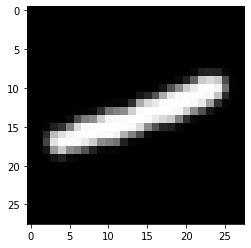

In [13]:
idx = 105
img = data.data[idx]
print("The number shown is the number: {}".format(data.targets[idx]) )
print(data.data[idx].shape)
plt.imshow(img , cmap = 'gray')
plt.show()

In [14]:
data_train = data.data[: TRAIN_SIZE_, :]
targets_train = data.targets[: TRAIN_SIZE_]

data_test = data.data[TRAIN_SIZE_ : TRAIN_SIZE_ + TEST_SIZE_, :]
targets_test = data.targets[TRAIN_SIZE_ : TRAIN_SIZE_ + TEST_SIZE_]

print(f"""
        Train size: {data_train.shape, targets_train.shape}
        Test size: {data_test.shape, targets_test.shape}
      """)


        Train size: (torch.Size([50000, 28, 28]), torch.Size([50000]))
        Test size: (torch.Size([10000, 28, 28]), torch.Size([10000]))
      


In [16]:
image, label = data_train[0], targets_train[0]
print(f"""
    Class presence in train: {np.unique(targets_train)}
    Class presence in test: {np.unique(targets_test)}
    Image shape: {image.shape}
    Label: {label}
""")


    Class presence in train: [0 1 2 3 4 5 6 7 8 9]
    Class presence in test: [0 1 2 3 4 5 6 7 8 9]
    Image shape: torch.Size([28, 28])
    Label: 8



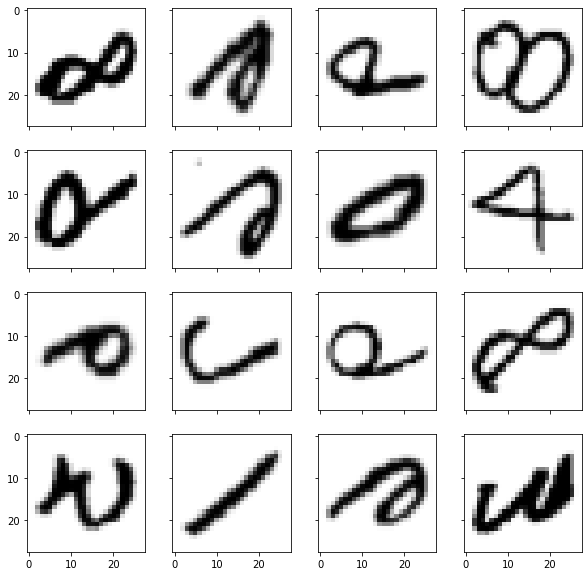

In [22]:
visualize_symbols(data_train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

# **Data properties & visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test class distribution')

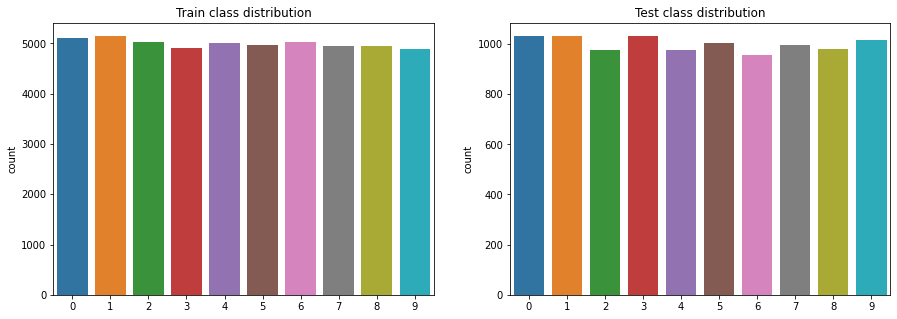

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(
    targets_train.numpy(), ax = axes[0]
)
axes[0].set_title('Train class distribution')

sns.countplot(
    targets_test.numpy(), 
    ax = axes[1]
)
axes[1].set_title('Test class distribution')

- 1st conclusion:  
    - 1 Dataset
    - 10 distinct symbols (for 'digits' split)
    - Approximately uniform class distribution
    - ~ 10% images per class
    - Digits are centered in the image and do not occupy the whole square (-> apply center crop)

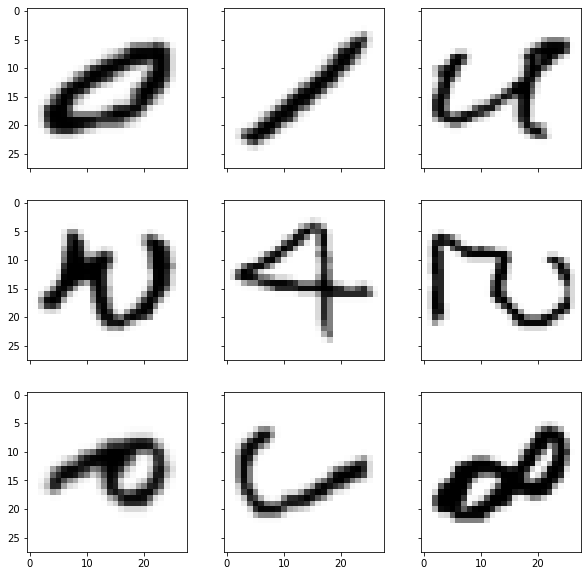

In [48]:
# Visualize first few symbols
visualize_labels(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    data = data_train,
    targets = targets_train
)

# **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [49]:
fix_seeds()

model = DBN(
    visible_units = VISIBLE_UNITS_,
    hidden_units = HIDDEN_UNITS_,
    k = K_,
    learning_rate = LEARNING_RATE_,
    learning_rate_decay = LR_DECAY_,
    initial_momentum = INIT_MOMENTUM_,
    final_momentum = FIN_MOMENTUM_,
    weight_decay = W_DECAY_,
    xavier_init = XAVIER_INIT_,
    increase_to_cd_k = INCREASE_TO_CD_K_,
    use_gpu = USE_GPU_
)

In [50]:
# %%capture

fix_seeds()

model.train_static(
    data_train,
    targets_train,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9536   |0.0326   |310.8721 |6.3037   |
|20    |0.8966   |0.0284   |289.7777 |5.8673   |
|30    |0.8753   |0.0285   |280.3728 |5.5946   |
|40    |0.8661   |0.0280   |277.4094 |5.6891   |
|50    |0.8621   |0.0296   |275.1747 |5.4796   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0747   |0.0324   |223.3940 |3.8660   |
|20    |0.9910   |0.0304   |215.1697 |3.9915   |
|30    |0.9759   |0.0296   |214.3481 |3.5538   |
|40    |0.9680   |0.0293   |213.2386 |3.4418   |
|50    |0.9636   |0.0291   |212.1487 |4.0587   |


# Linear read-outs. Receptive fields visualization

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

In [52]:
print(type(model.rbm_layers[0].W))
print(type(model.rbm_layers[0].W.numpy()))
print(model.rbm_layers[0].W.size())
print(model.rbm_layers[1].W.size())

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([784, 500])
torch.Size([500, 500])


### Preprocessing (filtering) learned weights matrices

In [53]:
# Converting and processing W matrices of hidden layers

learned_weights = [
    # We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])
    model.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(N_HIDDEN_LAYERS_)  
]

learned_weights_thresh = [
                          apply_threshold(weights_matrix, VISUALIZATION_THRESH_) 
                            for weights_matrix in learned_weights
]

### First hidden layer receptive fields

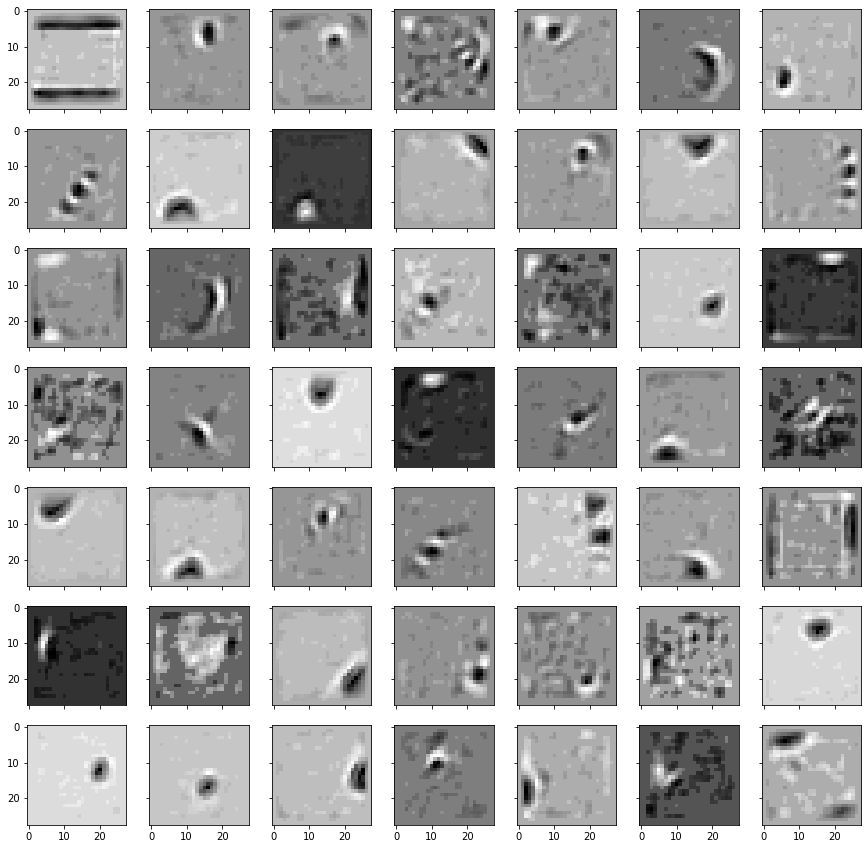

In [54]:
plot_layer_receptive_fields(
    # N_units * (img_size * img_size) - dimension of 1st hidden layer
    learned_weights_thresh[0],  
    num_subplots=49,
    img_height = IMG_SIZE_,
    img_width = IMG_SIZE_, 
    fig_size = (15, 15)
)

### Second hidden layer receptive field

- For example, in the architecture with units = [500, 500, 2000], the second hidden layer consists of 500 units, each associated with 500 units of the 1st hidden layer (500 x 500 matrix)
- We need to visualize (IMG_SIZE_ * IMG_SIZE_) images of 2nd hidden layer receptive fields
- The dimension of 1st hidden layer is n_units * (IMG_SIZE * IMG_SIZE).
- **Therefore**, we need to perform matrix multiplication, to turn (500 x 500) layer to (500 x (IMG_SIZE x IMG_SIZE)) layer

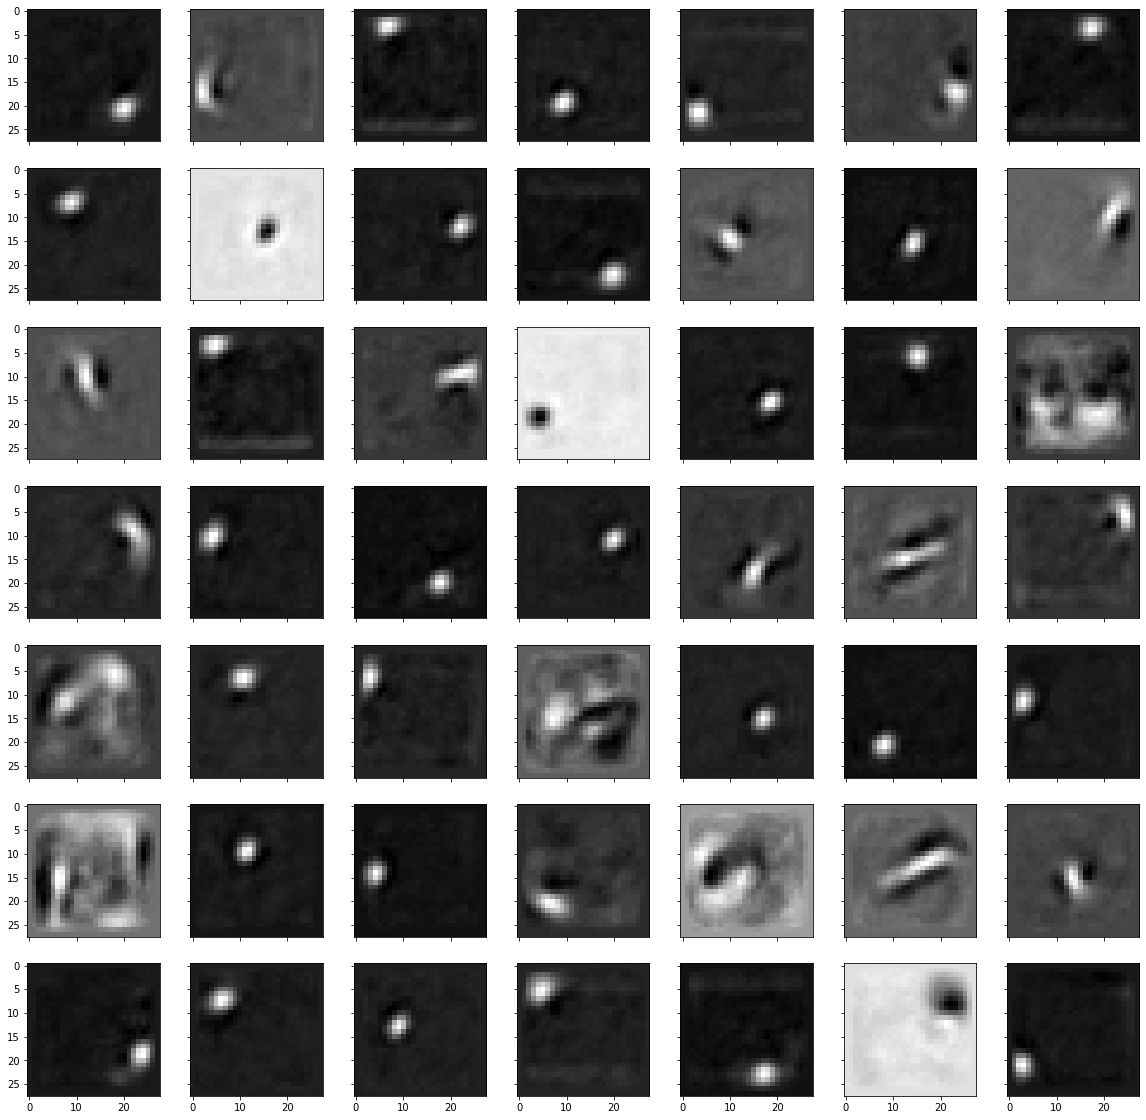

In [55]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 2
    ), 
    num_subplots = 49
)

### Third hidden layer receptive fields

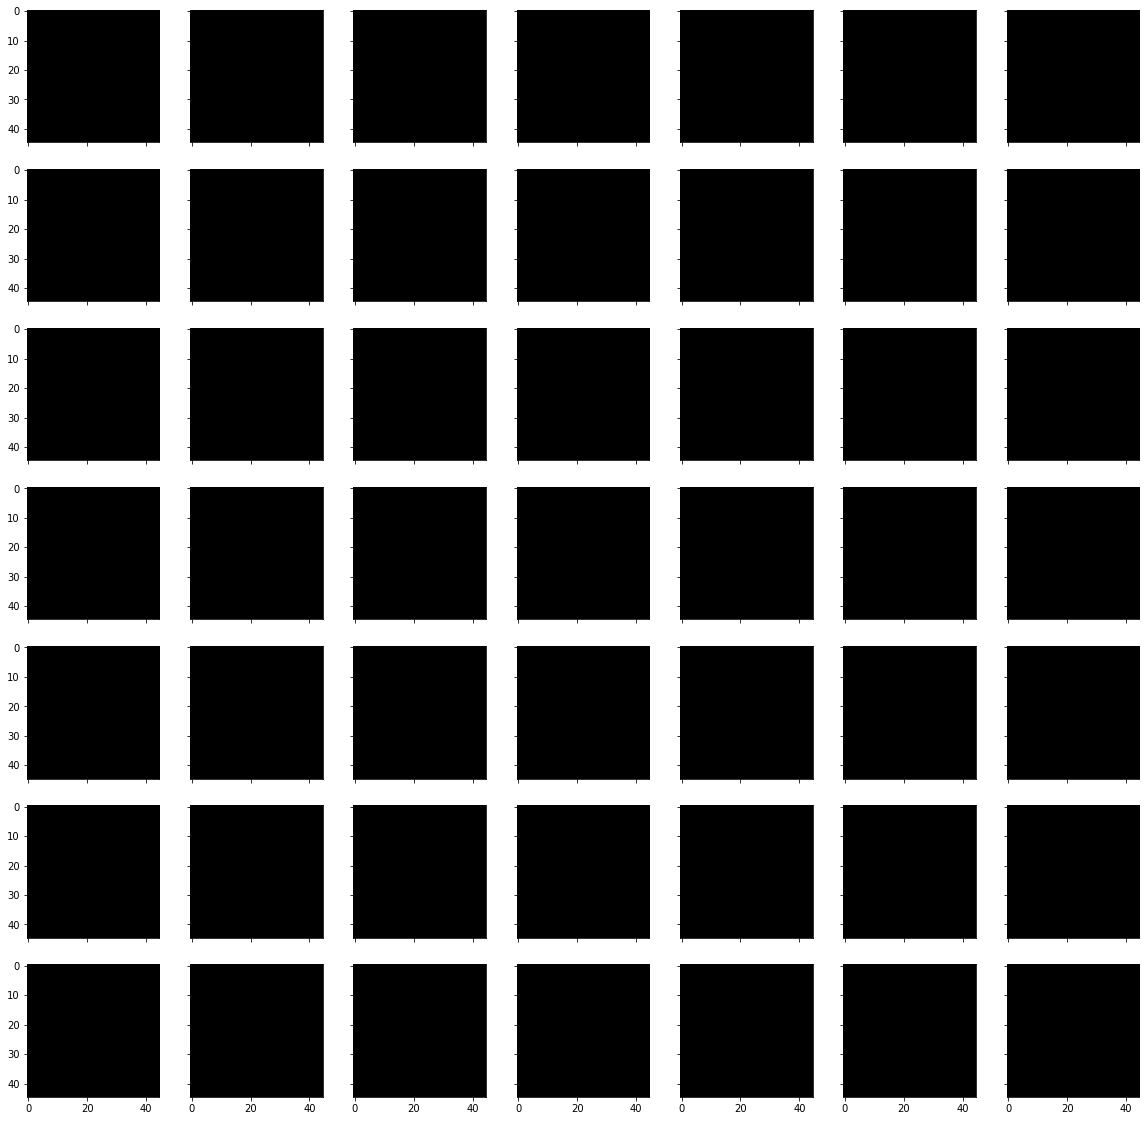

In [ ]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 3
    ), 
    num_subplots = 49
)

# Clustering internal representations

In [56]:
def get_layer_representation(input, model, layer_number):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = model.rbm_layers[layer_number].to_hidden(flattened_input)
    return hidden_repr

In [58]:
hidden0 = get_layer_representation(
    input = data_train,
    model = model,
    layer_number = 0
)

In [59]:
hidden1 = get_layer_representation(
    input = hidden0,
    model = model,
    layer_number = 1
)

In [62]:
def get_mask(labels, label):
    return labels.numpy() == label

def label_to_mean_hidden_repr(hidden_representation, images, labels):
    hidden_representation_np = hidden_representation.numpy()
    return {
        label: hidden_representation_np[get_mask(labels, label)].mean(axis=0)
        for label in np.unique(labels.numpy())
    }

def get_hidden_representation_matrix(label_to_mean_hidden_repr, labels):
    return np.concatenate(
        [np.expand_dims(
            label_to_mean_hidden_repr[label], axis = 0
        )
        for label in np.unique(labels.numpy())]
    )

In [63]:
label_to_mean0 = label_to_mean_hidden_repr(
    hidden0,
    data_train,
    targets_train
)

label_to_mean1 = label_to_mean_hidden_repr(
    hidden1,
    data_train,
    targets_train
)

In [64]:
mean_hidd_repr_mat0 = get_hidden_representation_matrix(
    label_to_mean0,
    targets_train
)

mean_hidd_repr_mat1 = get_hidden_representation_matrix(
    label_to_mean1,
    targets_train
)

In [65]:
def plot_dendrogram(mean_repr_matrix, title = ''):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)
    return dendrogram

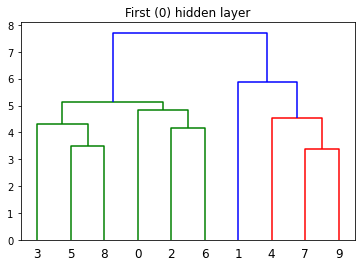

In [66]:
dendrogram0 = plot_dendrogram(mean_hidd_repr_mat0, title = 'First (0) hidden layer')

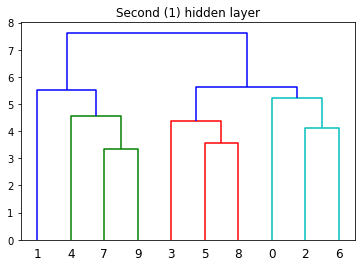

In [67]:
dendrogram1 = plot_dendrogram(
    mean_hidd_repr_mat1,
    title = 'Second (1) hidden layer'
)

In [69]:
# import pickle

# with open('DBN.pkl', 'wb') as outp:
#     pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [70]:
# with open('DBN.pkl', 'rb') as inp:
#     model2 = pickle.load(inp)

# Readout layer train

In [79]:
def _train(network, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)  # .squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)  # because 10 classes. You declare input and output

  def forward(self, x):  # called when applied on some data, basic method
    return self.linear(x)

In [81]:
rbm_layer_size = model.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size, class_num = 10)

# As input - hidden representation
_train(
    perceptron_first_hidden, 
    hidden0, 
    targets = targets_train, 
    epochs=1500
)

epoch 0/1500, loss = 2.278415
epoch 100/1500, loss = 0.651417
epoch 200/1500, loss = 0.461273
epoch 300/1500, loss = 0.385054
epoch 400/1500, loss = 0.341852
epoch 500/1500, loss = 0.313217
epoch 600/1500, loss = 0.292452
epoch 700/1500, loss = 0.276485
epoch 800/1500, loss = 0.263692
epoch 900/1500, loss = 0.253122
epoch 1000/1500, loss = 0.244181
epoch 1100/1500, loss = 0.236477
epoch 1200/1500, loss = 0.229736
epoch 1300/1500, loss = 0.223764
epoch 1400/1500, loss = 0.218419


In [82]:
# Now we calculate hidden representations on the test dataset
def compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

hidden_test = get_layer_representation(
    input = data_test,
    model = model,
    layer_number = 0
)
predictions_test = perceptron_first_hidden(
    hidden_test
)

In [83]:
compute_accuracy(
    predictions_test,
    targets_test
)

0.9434999823570251

In [84]:
# import pickle

# with open('Perceptron1hidden.pkl', 'wb') as outp:
#     pickle.dump(perceptron_first_hidden, outp, pickle.HIGHEST_PROTOCOL)

# FFNN comparison

In [87]:
class FeedForward(torch.nn.Module):
  def __init__(self, 
               first_hidden_layer_size,
               class_num,
               input_size
               ):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, class_num)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [88]:
ffnn = FeedForward(
    first_hidden_layer_size = 500,
    class_num = 10,
    input_size = 784
)

In [96]:
_train(
    ffnn,
    data_train.reshape(
        (data_train.shape[0], data_train.shape[1] * data_train.shape[2])
    ),
    targets = targets_train,
    epochs = 120
)

epoch 0/120, loss = 2.310006
epoch 10/120, loss = 2.161685
epoch 20/120, loss = 2.002908
epoch 30/120, loss = 1.821530
epoch 40/120, loss = 1.624765
epoch 50/120, loss = 1.429251
epoch 60/120, loss = 1.250645
epoch 70/120, loss = 1.097547
epoch 80/120, loss = 0.971652
epoch 90/120, loss = 0.870275
epoch 100/120, loss = 0.789130
epoch 110/120, loss = 0.723931


In [97]:
preds_ffnn = ffnn(
    data_test.reshape(
        (data_test.shape[0], data_test.shape[1] * data_test.shape[2])
    )
)
compute_accuracy(
    preds_ffnn,
    targets_test
)

0.8657000064849854

In [98]:
# with open('FFNN.pkl', 'wb') as outp:
#     pickle.dump(ffnn, outp, pickle.HIGHEST_PROTOCOL)

# Robustness to noise

In [99]:
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(mnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor

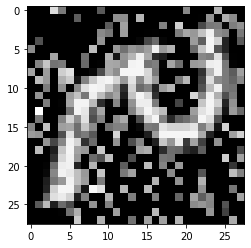

In [105]:
noise_level = 0.3
data_test_with_noise = inject_noise(data_test, noise_level)
_ = plt.imshow(data_test_with_noise[1000].reshape(28, 28), cmap="gray")

In [107]:
def accuracy_at_noise_level(
    noisy_input,
    targets,

    rbm_model,
    hidden_layer_number,

    perceptron_model,
    ffnn_model
):
  
  hidden_repr_noisy = get_layer_representation(noisy_input, rbm_model, hidden_layer_number)

  predictions_hidden = perceptron_model(hidden_repr_noisy)
  predictions_ffnn = ffnn_model(noisy_input.reshape(
      (noisy_input.shape[0], noisy_input.shape[1] * noisy_input.shape[2]))
  )
  
  acc_hidden = compute_accuracy(predictions_hidden, targets)
  acc_ffnn = compute_accuracy(predictions_ffnn, targets)
  return acc_hidden, acc_ffnn

In [114]:
acc_hidden, acc_ffnn = accuracy_at_noise_level(
    noisy_input = inject_noise(data_test, noise_level = 0.2),
    targets = targets_test,

    rbm_model = model,
    hidden_layer_number = 0,

    perceptron_model = perceptron_first_hidden,
    ffnn_model = ffnn
)

In [115]:
acc_hidden, acc_ffnn

(0.8424000144004822, 0.8501999974250793)